In [1]:
import vmas

import torch
import torch.nn as nn
from torch import multiprocessing

import matplotlib.pyplot as plt
import numpy as np

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

### Hyperparameters

In [2]:
# Device
is_fork = multiprocessing.get_start_method() == 'fork'
device = (
    torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device('cpu')
)
vmas_device = device

# Epsilon-greedy
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.999  # Exploration decay rate
epsilon_min = 0.01  # Minimum exploration rate

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lr_agents = 0.001  # learning rate for agents
lr_critic = 0.001  # learning rate for critic

# Environment
scenario_name = "dropout"

num_epochs = 1024  # Total number of training epochs, i.e. number of steps
max_steps = 128  # Episode steps before reset
num_vmas_envs = 1  # Number of vectorized environments to simulate at once

n_agents = 1 # Number of agents in the environment

### Environment

In [3]:
env = vmas.make_env(
    scenario=scenario_name, # Name of the scenario
    num_envs=num_vmas_envs,
    continuous_actions=False,  # Use discrete actions
    max_steps=max_steps,
    device=vmas_device,
    dict_spaces=True, # Use a dictionary for the observation and action spaces, instead of a tuple

    # Scenario custom args
    n_agents=n_agents,
)

print("Action spaces:", env.action_space)
print("Observation spaces:", env.observation_space)

# Get list of agents
agents = [agent.name for agent in env.agents]

# Get the name of the first agent
first_agent = agents[0]

# Obtain the size of the action space
action_size = env.action_space[first_agent].n

# Obtain the size of the observation space
observation_size = env.observation_space[first_agent].shape[0]

print("Action size:", action_size)
print("Observation size:", observation_size)

Action spaces: Dict('agent_0': Discrete(9))
Observation spaces: Dict('agent_0': Box(-inf, inf, (7,), float32))
Action size: 9
Observation size: 7


### PPO Network and Agent

In [4]:
# Actor-Critic network
class Actor(nn.Module):
    def __init__(self, action_size, observation_size, hidden_size=64):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(observation_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr_agents)

    def forward(self, obs):
        x = torch.relu(self.fc1(obs))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.out(x))

class Critic(nn.Module):
    def __init__(self, observation_size, hidden_size=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(observation_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr_critic)

    def forward(self, obs):
        x = torch.relu(self.fc1(obs))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# PPO algorithm
def update(experience, actor, critic, updates_per_iter=5, df=gamma, eps=clip_epsilon):
    # Initialize rewards to go
    rtgs = 0
    # Unpack experience
    for observations, actions, rewards, dones in reversed(experience):
        # Compute rewards to go
        rtgs = rtgs * df + rewards

        # Save previous policy
        prev_policy = actor(observations).detach()

        # Update policy
        for i in range(updates_per_iter):
            # Compute advantage estimation
            advantage = rtgs - critic(observations)

            # Compute ratio between new and old policy, i.e. pi(a|s) / pi_old(a|s)
            ratio = torch.exp(torch.log(prev_policy[actions]) - torch.log(actor(observations)))

            # Compute clipped ratio
            clipped_ratio = torch.clamp(ratio, 1 - eps, 1 + eps)

            # Compute actor loss
            actor_loss = -torch.min(ratio * advantage, clipped_ratio * advantage)
            actor_loss = torch.mean(actor_loss)

            # Update policy via stochastic gradient descent (Adam)
            actor.optimizer.zero_grad()
            actor_loss.backward()
            actor.optimizer.step()

            # Compute critic loss
            critic_loss = torch.mean((rtgs - critic(observations)) ** 2)

            # Update critic via stochastic gradient descent (Adam)
            critic.optimizer.zero_grad()
            critic_loss.backward()
            critic.optimizer.step()

def get_action(obs, actor):
    # Get actions for each simultaneous environment
    actions = []
    for o in obs:
        actions.append(actor(o).argmax().item())

    return torch.tensor(actions)

# Create PPO agents
agent_policy = Actor(action_size, observation_size).to(device)
critic = Critic(observation_size).to(device)

In [12]:
def update_plot_multi_agent(episode, max_episodes, reward_history, show_result=False):
    plt.figure(1)

    if show_result:
        plt.title(f'Final Result:')
    else:
        plt.clf()
        plt.title(f"Episode {episode} of {max_episodes}")
    plt.xlabel('Episode')
    plt.ylabel('Mean reward')

    #plt.plot(reward_history)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training

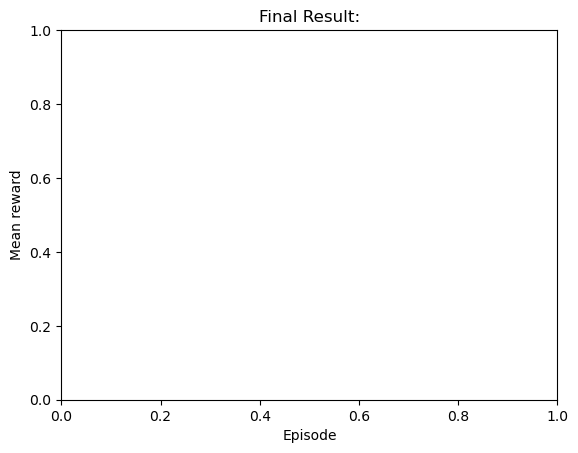

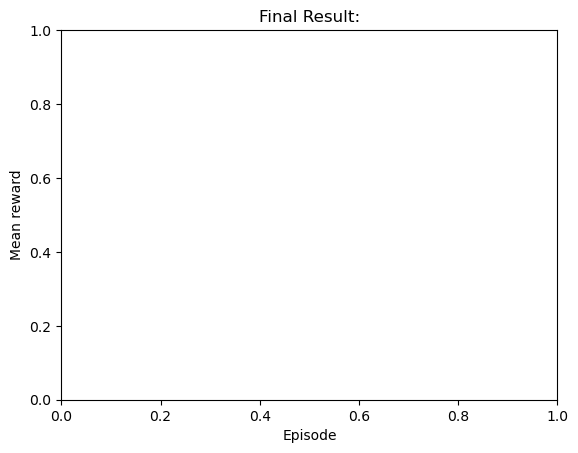

In [13]:
plt.ion()
reward_means = []

# Initialize the environment
observations = env.reset()

# Save the experience of each agent for use in PPO training
experience = [{agent.name: [] for agent in env.agents} for _ in range(num_vmas_envs)]

# Train for num_epochs
for e in range(1, num_epochs):

    # Epsilon-greedy exploration
    if epsilon > np.random.rand():
        actions = {agent.name: env.get_random_action(agent) for agent in env.agents}
    else:
        # Get actions for each agent
        actions = {agent.name: get_action(observations[agent.name], agent_policy) for agent in env.agents}

    # Step the environment
    observations, rewards, done, info = env.step(actions)

    # Save the experience of each agent
    for env_idx in range(num_vmas_envs):
        for agent in env.agents:
            experience[env_idx][agent.name].append((observations[agent.name][env_idx], actions[agent.name][env_idx], rewards[agent.name][env_idx], done[env_idx]))        

    # Reset the environment if done
    for i in range(num_vmas_envs):
        if done[i]:

            # Update the PPO
            for agent in env.agents:
                update(experience[i][agent.name], agent_policy, critic)

            # Reset the environment
            observations = env.reset_at(i)
            experience[i] = {agent.name: [] for agent in env.agents}

    # Get the average reward of all simulations, this assumes that all agents have the same reward
    reward_means.append(sum(rewards[first_agent]) / num_vmas_envs)

    # Update epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Update plot
    update_plot_multi_agent(e, num_epochs, reward_means)

update_plot_multi_agent(e + 1, num_epochs, reward_means, show_result=True)
plt.ioff()

### Testing

In [ ]:
observations = env.reset()
done = [False]

while not done[0]:
    #actions = {agent.name: env.get_random_action(agent) for agent in env.agents}
    actions = {agent.name: get_action(observations[agent.name], agent_policy) for agent in env.agents}
    observations, rewards, done, info = env.step(actions)

    # Render the environment
    env.render(mode="human")

In [ ]:
# Close the environment viewer
env.viewer.close()